# Some integration tests for online-variance-based oracle algorithm (`VarianceRegressor`)

In [1]:
%matplotlib inline
import time
import timeit
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from types import SimpleNamespace
from typing import Sequence, Callable, Tuple, Optional
from tqdm.notebook import tqdm

from sklearn import metrics

from bioslds.arma_hsmm import ArmaHSMM
from bioslds.arma import make_random_arma, Arma
from bioslds.regressors import VarianceRegressor, transform_ar
from bioslds.variance import OnlineVariance
from bioslds import sources
from bioslds.plotting import FigureManager, show_latent
from bioslds.cluster_quality import calculate_sliding_score, unordered_accuracy_score
from bioslds.dataset import RandomArmaDataset

## Check performance on randomly switching AR(3)s

In [2]:
rng = np.random.default_rng(1)

two_ar3 = SimpleNamespace(
    arma1=make_random_arma(3, 0, rng, default_source=sources.GaussianNoise(1)),
    arma2=make_random_arma(3, 0, rng, default_source=sources.GaussianNoise(2)),
    n_samples=100_000,
    n_features=3,
    variance_rate=0.05,
)
two_ar3.models = [two_ar3.arma1, two_ar3.arma2]
two_ar3.arma_hsmm = ArmaHSMM(two_ar3.models, min_dwell=15, dwell_times=50,)
two_ar3.n_models = len(two_ar3.models)

two_ar3.sig, two_ar3.u, two_ar3.usage_seq = two_ar3.arma_hsmm.transform(
    two_ar3.n_samples, return_input=True, return_usage_seq=True,
)

two_ar3.weights = [_.a for _ in two_ar3.models]

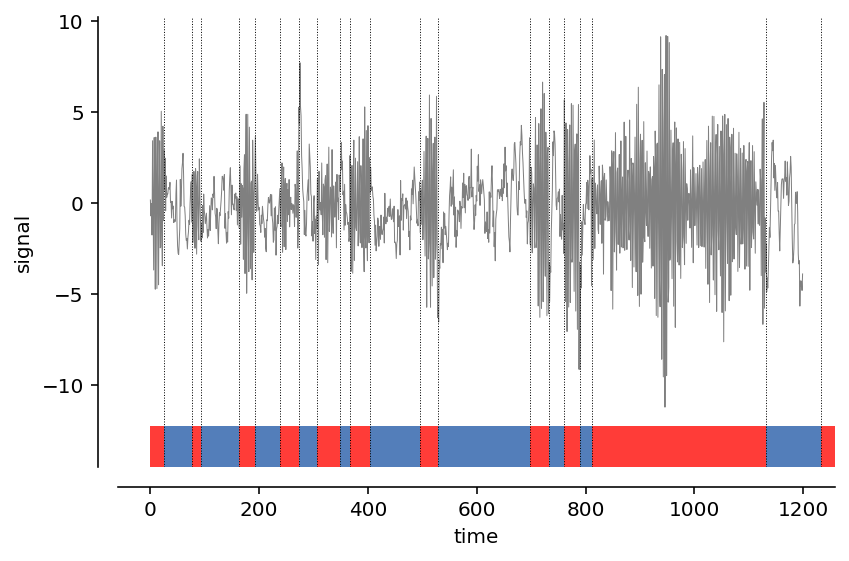

In [3]:
with FigureManager() as (_, ax):
    ax.plot(two_ar3.sig[:1200], c="gray", lw=0.5)
    ax.set_xlabel("time")
    ax.set_ylabel("signal")

    show_latent(two_ar3.usage_seq, bar_location="bottom", ax=ax)

In [4]:
two_ar3.regressor = VarianceRegressor(
    two_ar3.weights, variance_kws={"rate": two_ar3.variance_rate}
)
two_ar3.inferred_r, two_ar3.history = transform_ar(
    two_ar3.regressor, two_ar3.sig, progress=tqdm, monitor=["prediction_error.output_"],
)
two_ar3.inferred_usage = np.argmax(two_ar3.inferred_r, axis=1)

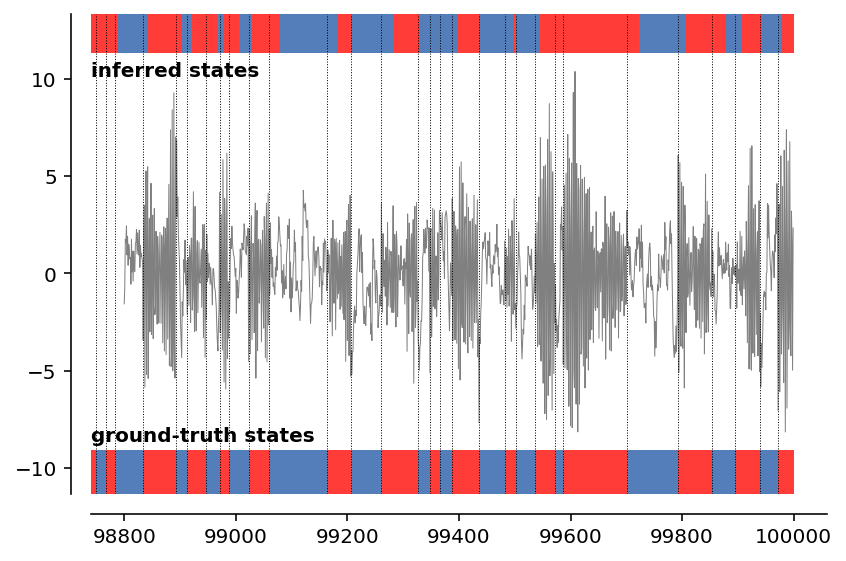

In [5]:
with FigureManager() as (_, ax):
    ax.plot(
        np.arange(two_ar3.n_samples - 1200, two_ar3.n_samples),
        two_ar3.sig[-1200:],
        lw=0.5,
        c="gray",
    )
    show_latent(
        two_ar3.inferred_usage, show_vlines=False, shift=two_ar3.n_features, ax=ax
    )
    show_latent(two_ar3.usage_seq, bar_location="bottom", ax=ax)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

In [6]:
two_ar3.score_loc, two_ar3.score = calculate_sliding_score(
    metrics.adjusted_rand_score,
    two_ar3.usage_seq,
    two_ar3.inferred_usage,
    progress=tqdm,
)

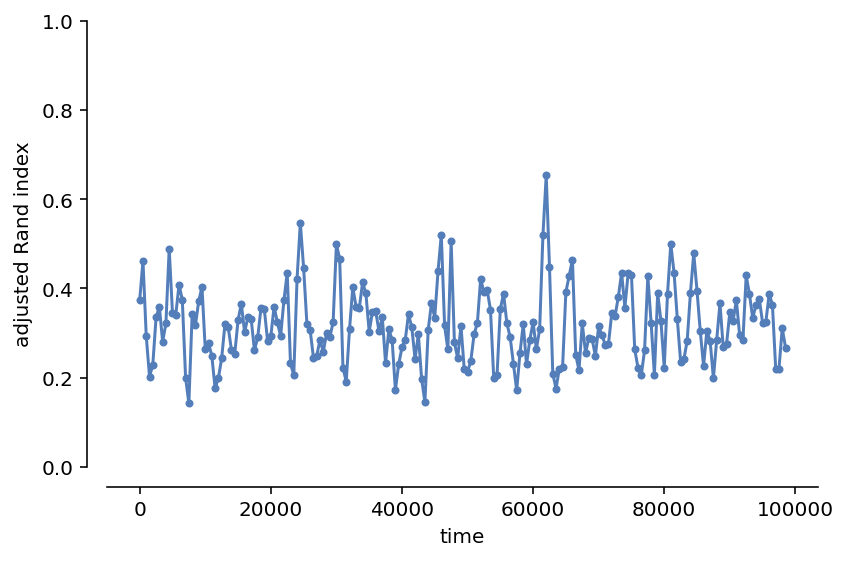

In [7]:
with FigureManager() as (_, ax):
    ax.plot(two_ar3.score_loc, two_ar3.score, '.-')
    ax.set_xlabel("time")
    ax.set_ylabel("adjusted Rand index")
    ax.set_ylim(0, 1)

In [8]:
two_ar3.score_loc_acc, two_ar3.score_acc = calculate_sliding_score(
    unordered_accuracy_score,
    two_ar3.usage_seq,
    two_ar3.inferred_usage,
    progress=tqdm,
)

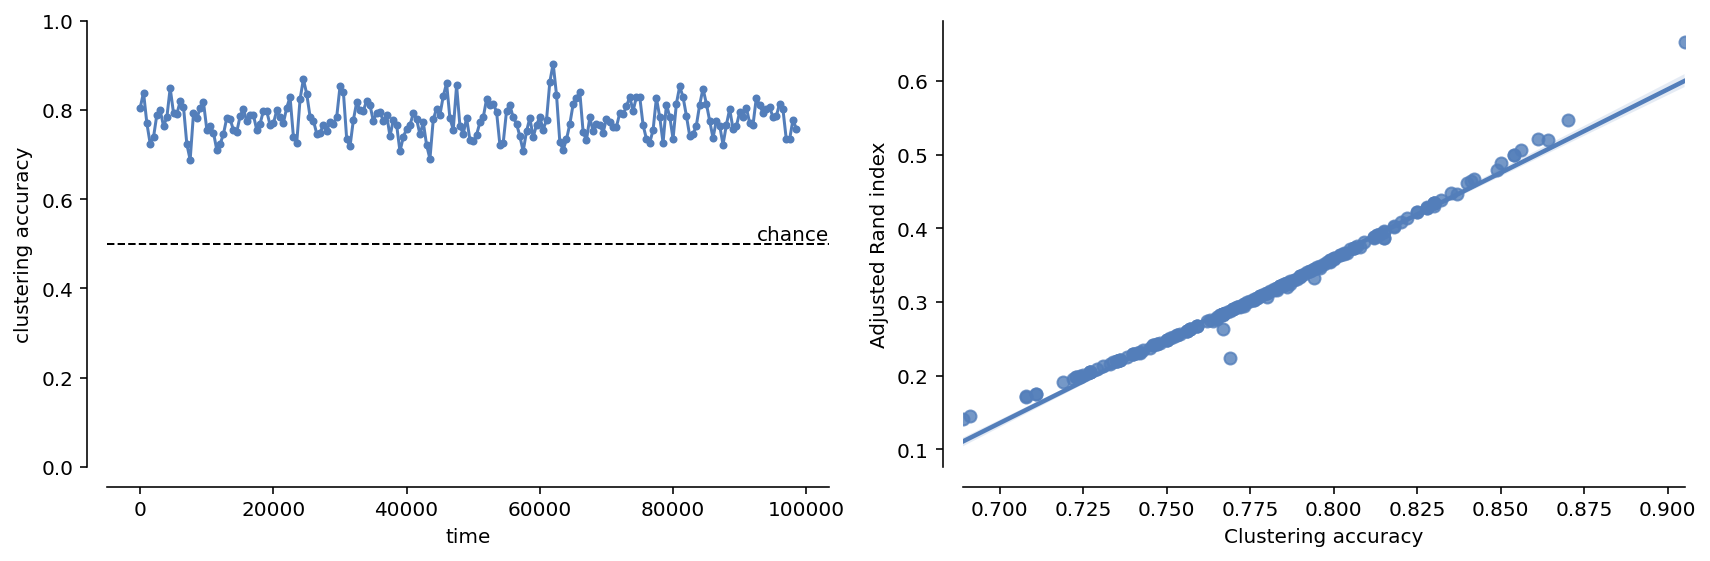

In [9]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot(two_ar3.score_loc_acc, two_ar3.score_acc, ".-")
    ax1.set_xlabel("time")
    ax1.set_ylabel("clustering accuracy")
    ax1.axhline(0.5, ls="--", lw=1, c="k")
    ax1.annotate(
        "chance",
        (ax.get_xlim()[1], 0.5),
        horizontalalignment="right",
        verticalalignment="bottom",
    )
    ax1.set_ylim(0, 1)

    sns.regplot(x=two_ar3.score_acc, y=two_ar3.score, ax=ax2)
    ax2.set_xlabel("Clustering accuracy")
    ax2.set_ylabel("Adjusted Rand index")

## An example using `Dataset`

In [10]:
rng = np.random.default_rng(2)

dataset_two_arma = SimpleNamespace(
    n_signals=2,
    n_samples=500_000,
    arma_orders=[(3, 1), (2, 3)],
    fix_scale=1.0,
    n_features=5,
    streak_len=40,
    variance_rate=0.05,
)
dataset_two_arma.n_models = len(dataset_two_arma.arma_orders)
dataset_two_arma.dataset = RandomArmaDataset(
    dataset_two_arma.n_signals,
    dataset_two_arma.n_samples,
    arma_orders=dataset_two_arma.arma_orders,
    min_dwell=15,
    dwell_times=dataset_two_arma.streak_len,
    fix_scale=dataset_two_arma.fix_scale,
)

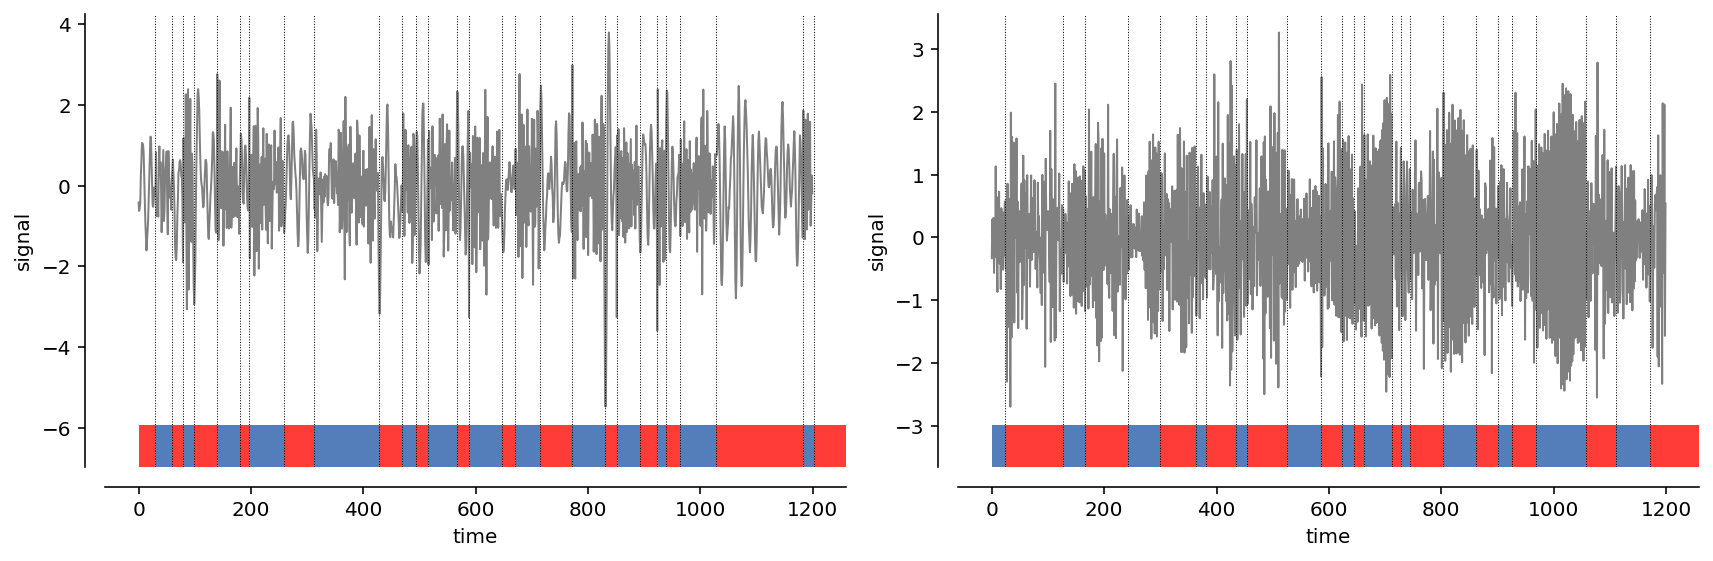

In [11]:
with FigureManager(1, dataset_two_arma.n_signals) as (_, axs):
    for ax, sig in zip(axs, dataset_two_arma.dataset):
        ax.plot(sig.y[:1200], c="gray", lw=1)
        ax.set_xlabel("time")
        ax.set_ylabel("signal")

        show_latent(sig.usage_seq, bar_location="bottom", ax=ax)

We won't use the second signal in the dataset beyond this point.

In [12]:
dataset_two_arma.sig = dataset_two_arma.dataset[0]
dataset_two_arma.weights = np.zeros(
    (dataset_two_arma.n_models, np.max([_[0] for _ in dataset_two_arma.arma_orders]))
)
for i in range(dataset_two_arma.n_models):
    crt_a = dataset_two_arma.dataset.armas[0][i].a
    dataset_two_arma.weights[i, : len(crt_a)] = crt_a

dataset_two_arma.regressor = VarianceRegressor(
    dataset_two_arma.weights, variance_kws={"rate": dataset_two_arma.variance_rate}
)
dataset_two_arma.inferred_r, dataset_two_arma.history = transform_ar(
    dataset_two_arma.regressor,
    dataset_two_arma.sig.y,
    progress=tqdm,
    monitor=["prediction_error.output_"],
)
dataset_two_arma.inferred_usage = np.argmax(dataset_two_arma.inferred_r, axis=1)

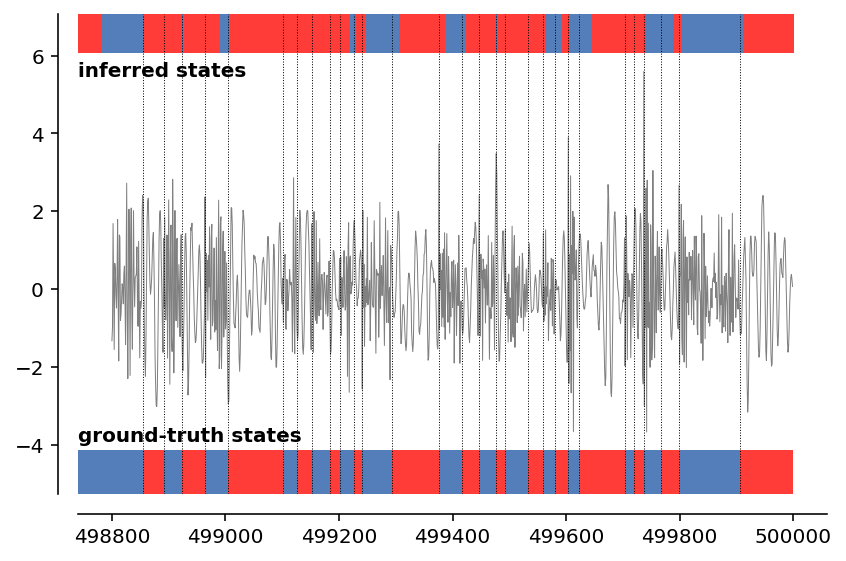

In [13]:
with FigureManager() as (_, ax):
    ax.plot(
        np.arange(dataset_two_arma.n_samples - 1200, dataset_two_arma.n_samples),
        dataset_two_arma.sig.y[-1200:],
        lw=0.5,
        c="gray",
    )
    show_latent(
        dataset_two_arma.inferred_usage,
        show_vlines=False,
        shift=dataset_two_arma.n_features,
        ax=ax,
    )
    show_latent(dataset_two_arma.sig.usage_seq, bar_location="bottom", ax=ax)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

In [14]:
dataset_two_arma.score_loc, dataset_two_arma.score = calculate_sliding_score(
    metrics.adjusted_rand_score,
    dataset_two_arma.sig.usage_seq,
    dataset_two_arma.inferred_usage,
    progress=tqdm,
)

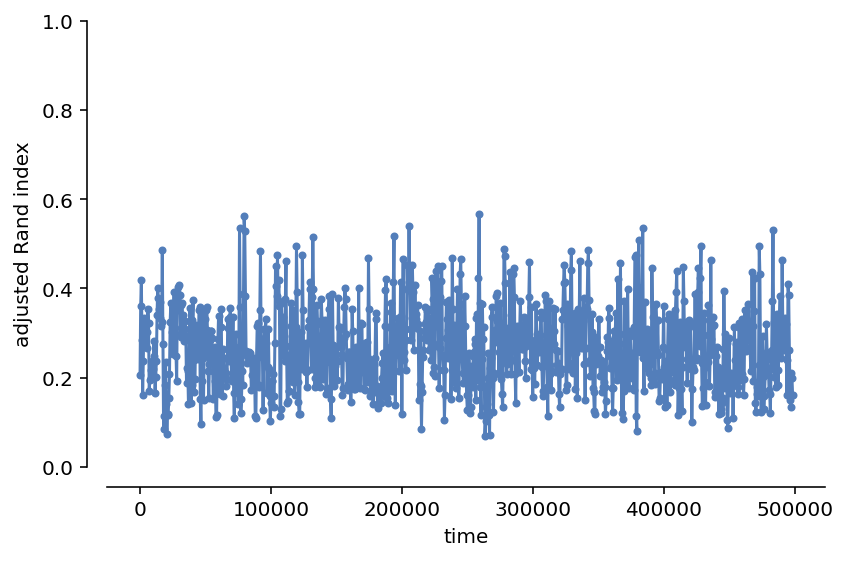

In [15]:
with FigureManager() as (_, ax):
    ax.plot(dataset_two_arma.score_loc, dataset_two_arma.score, '.-')
    ax.set_xlabel("time")
    ax.set_ylabel("adjusted Rand index")
    ax.set_ylim(0, 1)

In [16]:
dataset_two_arma.score_loc_acc, dataset_two_arma.score_acc = calculate_sliding_score(
    unordered_accuracy_score,
    dataset_two_arma.sig.usage_seq,
    dataset_two_arma.inferred_usage,
    progress=tqdm,
)

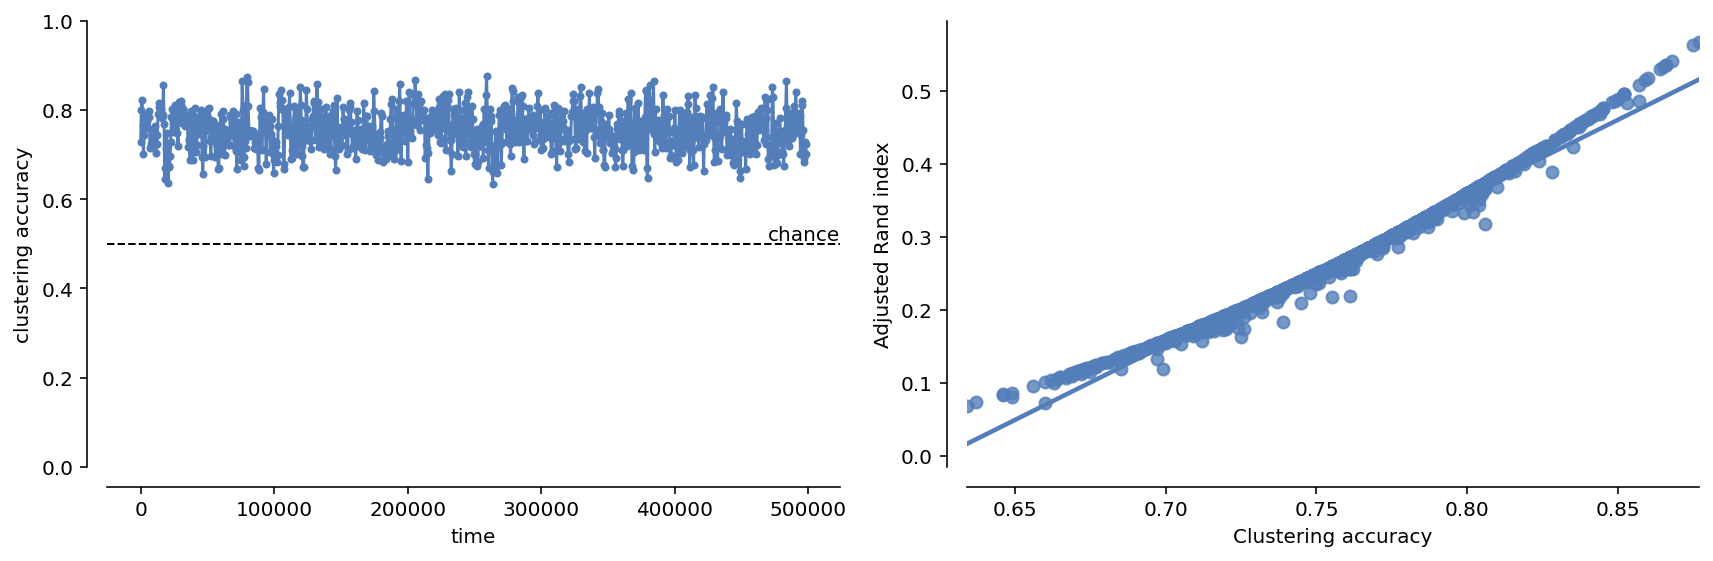

In [17]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot(dataset_two_arma.score_loc_acc, dataset_two_arma.score_acc, ".-")
    ax1.set_xlabel("time")
    ax1.set_ylabel("clustering accuracy")
    ax1.axhline(0.5, ls="--", lw=1, c="k")
    ax1.annotate(
        "chance",
        (ax.get_xlim()[1], 0.5),
        horizontalalignment="right",
        verticalalignment="bottom",
    )
    ax1.set_ylim(0, 1)

    sns.regplot(x=dataset_two_arma.score_acc, y=dataset_two_arma.score, ax=ax2)
    ax2.set_xlabel("Clustering accuracy")
    ax2.set_ylabel("Adjusted Rand index")

## Benchmark `VarianceRegressor.transform` speed

In [18]:
def benchmark_variance(
    variance: VarianceRegressor,
    sample_sizes: Sequence,
    progress: Callable = None,
    n_rep: int = 3,
    random_seed: int = 0,
    kws: Optional[dict] = None,
) -> Tuple[Sequence, np.ndarray]:
    """ Benchmark speed of `VarianceRegressor.transform`.
    
    This runs `VarianceRegressor.transform` for different sample
    sizes, benchmarking the execution speed.
    
    Parameters
    ----------
    variance
        Online-variance model to benchmark.
    sample_sizes
        Sequence indicating which sample sizes to use.
    progress
        Callable to track progress.
    n_rep
        Number of times to repeat the time measurement. The first time,
        `timeit`s `autorange` is used to determine a good number of
        iterations, then `repeat` is called with `n_rep - 1` repeats
        and `number` set to the count returned by `autorange`.
    random_seed
        Seed to use for pseudorandom number generation. This is used to
        create the predictor and dependent sequences used for learning.
    kws
        Other keyword arguments to pass to `variance.transform`.
    
    Returns a tuple of arrays, `(sample_sizes, times)`, with the first
    element, `sample_sizes`, simply a clone of the input argument, and the
    second element, `times`, indicating the times (in seconds) it took to
    transform each of the data sets with sizes given by `sample_sizes`. The
    timings are obtained by potentially running the task many times, using
    the `autorange` member from `timeit.Timer`.
    """
    if kws is None:
        kws = {}

    times = np.zeros(len(sample_sizes))
    if progress is None:
        progress = lambda it: it

    # generate a sequence long enough to work for all sample sizes
    n_samples = np.max(sample_sizes)

    rng = np.random.default_rng(random_seed)
    x = rng.normal(size=(n_samples, variance.n_features))
    y = rng.normal(size=n_samples)

    for i, n in enumerate(progress(sample_sizes)):
        variance_copy = copy.deepcopy(variance)
        crt_x = x[:n]
        crt_y = y[:n]
        timer = timeit.Timer(lambda: variance_copy.transform(X=crt_x, y=crt_y, **kws))
        count, total_time = timer.autorange()

        other_times = timer.repeat(n_rep - 1, count)
        best_time = min(total_time, np.min(other_times))

        times[i] = best_time / count

    return sample_sizes, times

In [19]:
speed_test = SimpleNamespace(
    model_sizes=[(2, 2), (5, 3), (3, 5), (5, 5)],
    sample_sizes=np.geomspace(10, 20000, 8).astype(int),
)

rng = np.random.default_rng(32)
speed_test.results = {}
speed_test.all_modes = OnlineVariance._available_modes
for crt_mode in tqdm(speed_test.all_modes, desc="mode"):
    for crt_args in tqdm(speed_test.model_sizes, desc="args"):
        crt_weights = rng.normal(size=(crt_args[0], crt_args[1]))
        crt_variance = VarianceRegressor(crt_weights)
        crt_variance.variance_norm._mode = crt_mode

        crt_sizes, crt_times = benchmark_variance(
            crt_variance, speed_test.sample_sizes, progress=tqdm
        )

        speed_test.results[crt_mode, crt_args] = {
            "variance": crt_variance,
            "sizes": crt_sizes,
            "times": crt_times,
        }

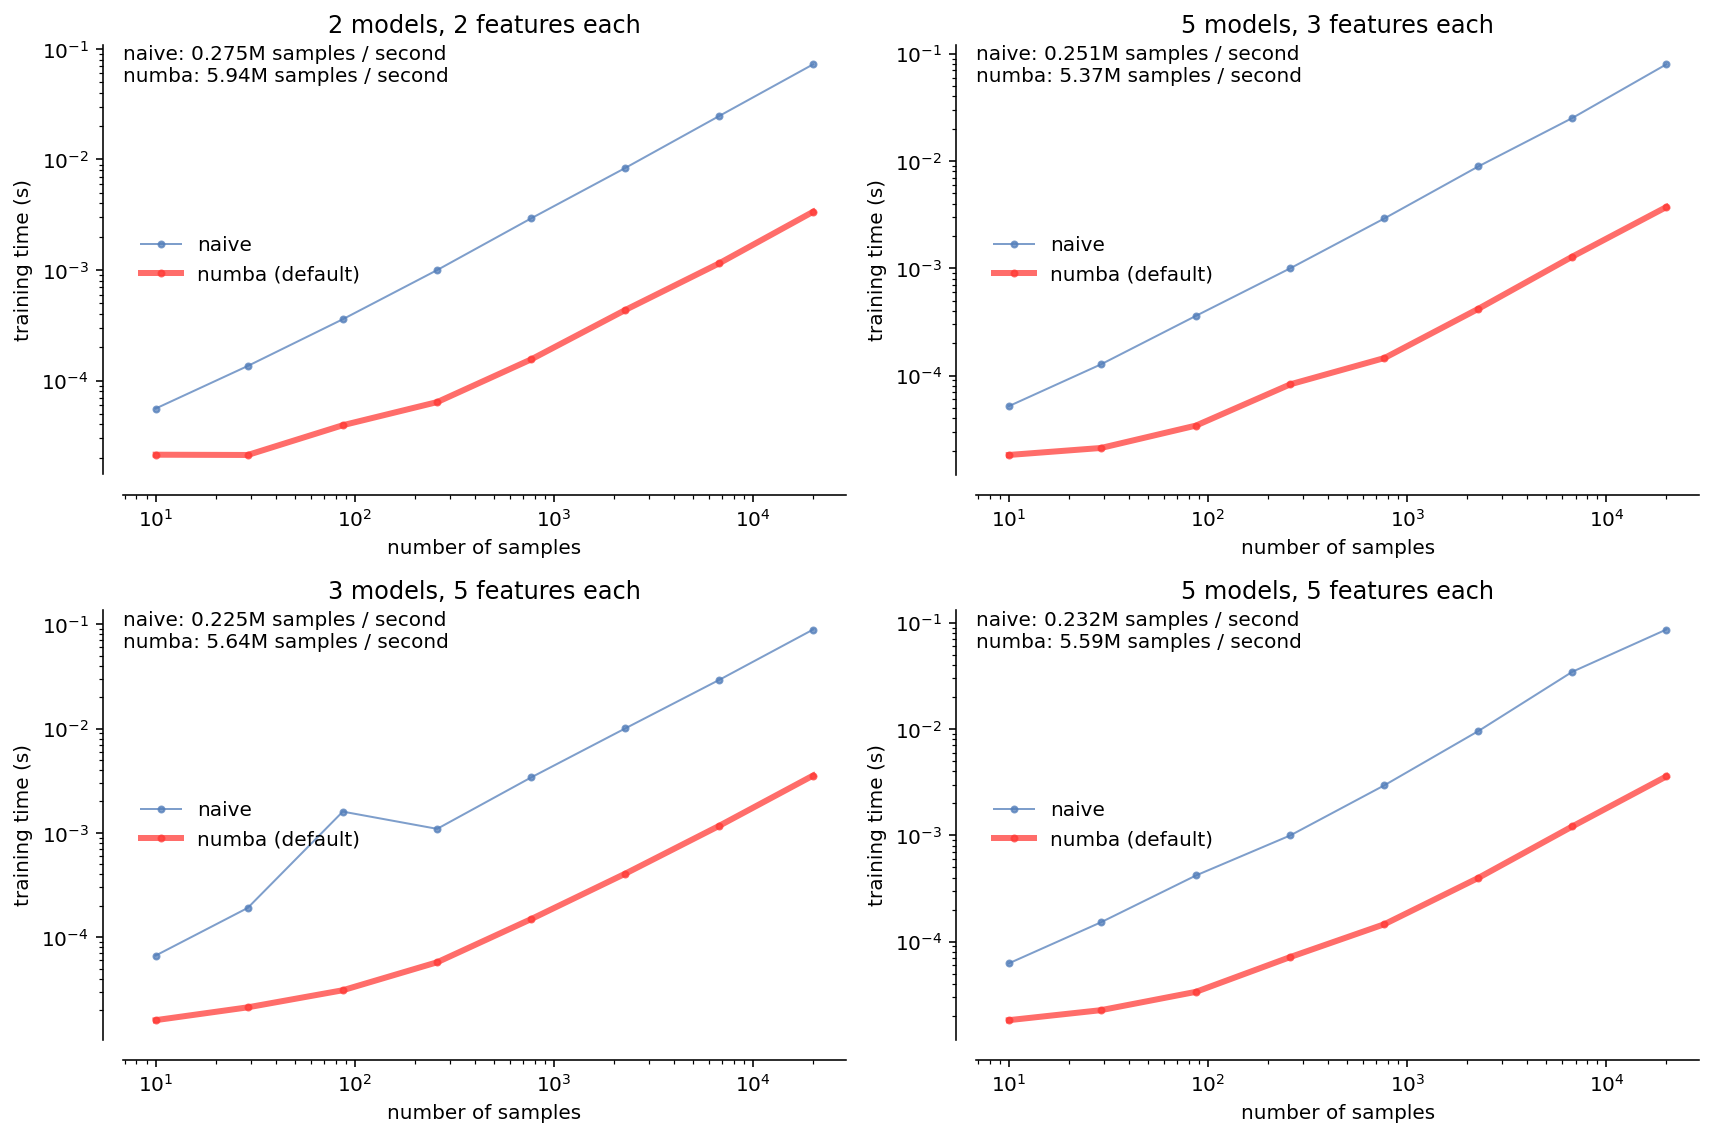

In [20]:
default_mode = OnlineVariance(2)._mode

n_rows = int(np.floor(np.sqrt(len(speed_test.model_sizes))))
n_cols = int(np.ceil(len(speed_test.model_sizes) / n_rows))
with FigureManager(n_rows, n_cols) as (_, axs):
    axs = axs.ravel()
    for i, ax in enumerate(axs):
        crt_rates = []
        crt_annot_list = []
        crt_args = speed_test.model_sizes[i]
        for crt_mode in speed_test.all_modes:
            crt_results = speed_test.results[crt_mode, crt_args]
            is_default = crt_mode == default_mode
            crt_mode_str = crt_mode
            crt_mode_label = str(crt_mode_str)
            if is_default:
                crt_mode_label += " (default)"

            ax.loglog(
                crt_results["sizes"],
                crt_results["times"],
                ".-",
                label=crt_mode_label,
                alpha=0.75,
                lw=3 if is_default else 1,
            )

            crt_rate = crt_results["sizes"][-1] / crt_results["times"][-1] / 1_000_000
            crt_rates.append(crt_rate)
            crt_annot_list.append(f"{crt_mode_str}: {crt_rate:.3g}M samples / second")

        crt_title = f"{crt_args[0]} models, {crt_args[1]} features each"
        ax.set_title(crt_title)
        ax.legend(frameon=False, loc="center left")

        ax.set_xlabel("number of samples")
        ax.set_ylabel("training time (s)")

        crt_annot = "\n".join(crt_annot_list)
        ax.annotate(
            crt_annot, (0.0, 1.0), xycoords="axes fraction", verticalalignment="top"
        )